# Classification of Malaria Cell Images

#### Edib Hamza Arslan

In this project my aim is using 3 different pretrained model to classify NIH dataset. They are 
* Xception
* Resnet152V2
* InceptionResNetV2

The reason of to chosing this pretrained models that they are top of the 3 models depend on keras applications page https://keras.io/api/applications/ (except the nasnet large because it's need large images). 

I used to transfer learning and fine tunining techinuques to retrain with NIH dataset. The top layer of that models are not includeded. Reason of that, they are trained 1000 objects, but I have only 2 object and they are parasitized and uninfected images. Finaly I evaluate the training results and I find which is the best model for this dataset.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

Malaria is a transmittable disease caused by the
parasites which belong to the Plasmodium family. Malaria
disease can be spread by the bite of the female mosquito. Every
year around 228 million people are affected by malaria around
the globe. The number of deaths due to malaria disease is almost
4,05,000. The number of children who died because of malaria
disease is 67% (2,72,000) around the globe. The Africa region
is inflicted by high malaria cases and high death rates.
The increase in the percentage of these deaths is due to the
failure to detect the disease early. The traditional mechanism to
detect the malaria disease is to visually examine the blood
smears for identifying red blood cells affected by malaria-
parasites under the microscope and the appearance of an
experienced technician. This method is inefficient due to the
absence of lab equipment, and the diagnosis is very dependent
on the seniority or experience of a person. The main intention of
this paper is to identify the presence or absence of malaria
parasites. To overcome the problems in the traditional malaria
detecting system, we develop an automated system to detect
malaria parasites to improve diagnostic accuracy. For this
implementation, we referred to the NIH dataset, which consists
of 27,558 images that belong to two classes.[1]

I try to classified the images (parasitized and uninfected), the problem type is supervised machine learning problem. 

I downloaded dataset from kaggle. To download this dataset, you have to Kaggle account, then you should download kaggle.json and submit your kaggle.json in google colab files.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 669M/675M [00:05<00:00, 110MB/s]
100% 675M/675M [00:05<00:00, 125MB/s]


In [ ]:
!unzip cell-images-for-detecting-malaria.zip

In [ ]:
import os
import shutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

I used keras with tensorflow 2 on google colab

## Data Understanding<a class="anchor" id="data_understanding"></a>

Data has 27,558 total images. They are equally seperated parasitized and uninfected folders. But the data is so big for disk. Therefore I used to generator. The generator basically sending images to model with defined batch size rather than taking all of them in disk. It helps to increase model performance and reduce the hardware requirements. 

To using generator, first of all we have to seperate data manually as train, validation and test folder. Each folder has 2 folders that names are parasitized and uninfected. Then we can give the data path to generator.

In [ ]:
parasitized_data_path = 'cell_images/Parasitized'
uninfected_data_path = 'cell_images/Uninfected'
TOTAL_DATA = len(os.listdir(parasitized_data_path)) + len(os.listdir(uninfected_data_path)) # 27,558

base_dir = 'Data'

train_dir = 'Data/train'
train_parasitized_dir = os.path.join(train_dir, 'parasitized')
train_uninfected_dir = os.path.join(train_dir, 'uninfected')

validation_dir = 'Data/validation'
validation_parasitized_dir = os.path.join(validation_dir, 'parasitized')
validation_uninfected_dir = os.path.join(validation_dir, 'uninfected')

test_dir = 'Data/test'
test_parasitized_dir = os.path.join(test_dir, 'parasitized')
test_uninfected_dir = os.path.join(test_dir, 'uninfected')


In [ ]:
if not os.path.exists(base_dir):
  os.mkdir(base_dir)

# Training data
if not os.path.exists(train_dir):
  os.mkdir(train_dir)

if not os.path.exists(train_parasitized_dir):
  os.mkdir(train_parasitized_dir)

if not os.path.exists(train_uninfected_dir):
  os.mkdir(train_uninfected_dir)

# Validation data
if not os.path.exists(validation_dir):
  os.mkdir(validation_dir)

if not os.path.exists(validation_parasitized_dir):
  os.mkdir(validation_parasitized_dir)

if not os.path.exists(validation_uninfected_dir):
  os.mkdir(validation_uninfected_dir)

# Test data
if not os.path.exists(test_dir):
  os.mkdir(test_dir)

if not os.path.exists(test_parasitized_dir):
  os.mkdir(test_parasitized_dir)

if not os.path.exists(test_uninfected_dir):
  os.mkdir(test_uninfected_dir)


In [ ]:
TOTAL_DATA = len(os.listdir(parasitized_data_path)) # 13779
TRAINING_PARTION = round(TOTAL_DATA * 0.8) # 11023
VALIDATION_PARTION = round(TOTAL_DATA * 0.1) # 1378
TEST_PARTION = round(TOTAL_DATA * 0.1) # 1378

def partioned_fnames_list(img_id_list):
  train_fnames = img_id_list[0:TRAINING_PARTION]
  validation_fnames = img_id_list[TRAINING_PARTION:TRAINING_PARTION + VALIDATION_PARTION]
  test_fnames = img_id_list[TRAINING_PARTION + VALIDATION_PARTION : TOTAL_DATA]
  return (train_fnames, validation_fnames, test_fnames)

def copy_files_to_destination_path(fnames, img_path, dst_dir):
  for fname in fnames:
    src = os.path.join(img_path, fname)
    dst = os.path.join(dst_dir, fname)
    shutil.copy(src, dst)

In [ ]:
if len(os.listdir(train_parasitized_dir)) == 0:
  parasitized_fnames = os.listdir(parasitized_data_path)
  parasitized_train_fnames, parasitized_validation_fnames, parasitized_test_fnames = partioned_fnames_list(parasitized_fnames)

  uninfected_fnames = os.listdir(uninfected_data_path)
  uninfected_train_fnames, uninfected_validation_fnames, uninfected_test_fnames = partioned_fnames_list(uninfected_fnames)


  copy_files_to_destination_path(parasitized_train_fnames, parasitized_data_path, train_parasitized_dir)
  copy_files_to_destination_path(parasitized_validation_fnames, parasitized_data_path, validation_parasitized_dir)
  copy_files_to_destination_path(parasitized_test_fnames, parasitized_data_path, test_parasitized_dir)

  copy_files_to_destination_path(uninfected_train_fnames, uninfected_data_path, train_uninfected_dir)
  copy_files_to_destination_path(uninfected_validation_fnames, uninfected_data_path, validation_uninfected_dir)
  copy_files_to_destination_path(uninfected_test_fnames, uninfected_data_path, test_uninfected_dir)
  print("Data seperation is successfully.")
else:
    print('Data is already splitted')

Data seperation is successfully.


## Data Preparation<a class="anchor" id="data_preparation"></a>

After I split data (%80 train %10 validation %10 test) to use generator, I create generator. The images size are (224, 224) rgb images. The batch size is 32. In this project I used 32, because generally the batch sizes chose as 2 and 2's power. But too much small or big numbers can cause overfit or underfit, therefore I chose 32 as a batch size. 

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32



train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)


Found 22048 files belonging to 2 classes.
Found 2754 files belonging to 2 classes.
Found 2756 files belonging to 2 classes.


Visualization of the images with their class names.

(32, 224, 224, 3)


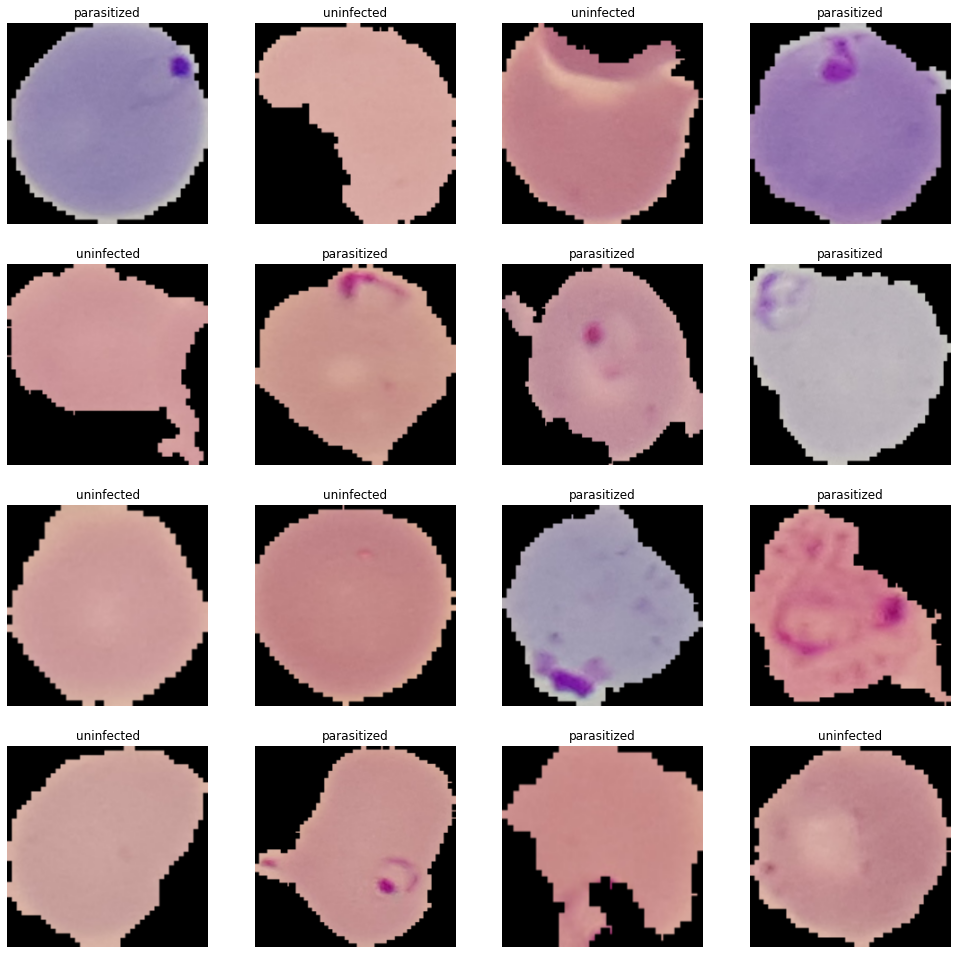

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(17, 17))
for images, labels in train_dataset.take(1):
  print(images.shape)
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The autone is increase the model performance depend on tensorflow documentations.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


I used data augmentation layer. Because of variety of the training data is important to decide the model is actually is learning or just overfitting the data. 

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(0.2, 0.3)),
  tf.keras.layers.experimental.preprocessing.RandomWidth(factor=(0.2, 0.3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Visualization of augmented image

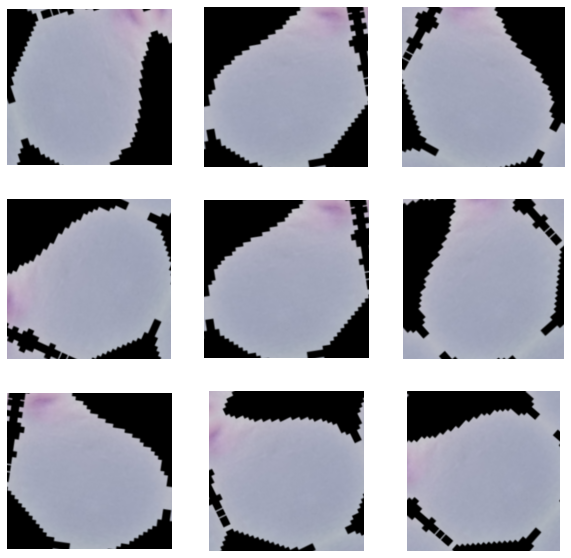

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Modeling<a class="anchor" id="modeling"></a>

I used 3 pretrained models they are ;
* Xception
* InceptionResnetV2
* Resnet152V2

<img src="./pretrained_models.png" alt="keras applications"/>




The image show the pretrained models with their accuracies. When I chosing to use one of them, I compare the accuracies. The top 3 best model is nasnet large, InceptionResnetV2 and Xception. But nasnet large is images sizes have to be (331, 331). Therefore I choice ResNet152V2.

When I initialize models, I didnt include top of the model because this pretrained models trained with different dataset and differenct classification size. I droped the top layer, freeze the other layer and I initialize my own model to top layer. This techinque is calling **transfer learning** . 

I initialized the top layer with global average pooling and droput. Of course, you can use different layer and diffrent layer numbers, but in this project I constant them for all models. The reasong of the chosing them is that I saw different classification problems are used them. 

The image shape is (224, 224, 3) for all models and dropout is 0.2 for all models.

When I using tranfer learning I used Adam optimizer and I save the models to my google drive because when working on colab, you can disconnected from colab and your trained model is removed. When I save drive, I can start training when they are left.

In [ ]:
def create_model(pretrained_model, preprocess_input, IMAGE_SHAPE, dropout=0.2 ):
  base_model = pretrained_model(input_shape=IMAGE_SHAPE, include_top=False)
  base_model.trainable = False
  
  inputs = tf.keras.Input(shape=IMAGE_SHAPE)
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  model = tf.keras.Model(inputs, outputs)
  return (base_model, model)


def train_model(model, lr, saved_model_path, EPOCHS, fine_tuning=False):
  if fine_tuning:
    optimizer = tf.keras.optimizers.RMSprop(lr=lr)
  else:
    optimizer = tf.keras.optimizers.Adam(lr=lr)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])
  
  path = '/content/drive/MyDrive/bbm469_dscp'
  save_path = os.path.join(path, saved_model_path)
  if not os.path.exists(save_path):
    os.mkdir(save_path)
  checkpoint_filepath = os.path.join(save_path, 'weights.{epoch:02d}-{val_loss:.2f}.h5')
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True,
      verbose=1)
  history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    callbacks=[model_checkpoint_callback] ) 
  return history

# https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function


def plot_graphs(epochs, acc_1, acc_2, acc_3, label_1, label_2, label_3, title, ylabel):
  plt.plot(epochs, acc_1, label=label_1)
  plt.plot(epochs, acc_2, label=label_2)
  plt.plot(epochs, acc_3, label=label_3)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()

def plot_history(history_resnet, history_inception_resnet, history_xception):
  
  # acc
  acc_resnet = history_resnet.history['accuracy']
  acc_incepres = history_inception_resnet.history['accuracy']
  acc_xception = history_xception.history['accuracy']

  # val_acc
  val_acc_resnet = history_resnet.history['val_accuracy']
  val_acc_incepres = history_inception_resnet.history['val_accuracy']
  val_acc_xception = history_xception.history['val_accuracy']

  # loss
  loss_resnet = history_resnet.history['loss']
  loss_incepres = history_inception_resnet.history['loss']
  loss_xception = history_xception.history['loss']
  
  # val_loss
  val_loss_resnet = history_resnet.history['val_loss']
  val_loss_incepres = history_inception_resnet.history['val_loss']
  val_loss_xception = history_xception.history['val_loss']

  epochs = range(1, len(acc_resnet) + 1)
  
  plot_graphs(epochs, acc_resnet, acc_incepres, acc_xception, "Resnet training", "Inception Resnet training", 'Xception training', 'Training acc', 'acc')
  plot_graphs(epochs, val_acc_resnet, val_acc_incepres, val_acc_xception, "Resnet training", "Inception Resnet training", 'Xception training', 'Training val acc', 'val acc')
  plot_graphs(epochs, loss_resnet, loss_incepres, loss_xception, "Resnet training", "Inception Resnet training", 'Xception training', 'Training loss', 'loss')
  plot_graphs(epochs, val_loss_resnet, val_loss_incepres, val_loss_xception, "Resnet training", "Inception Resnet training", 'Xception training', 'Training val_loss', 'val loss')

In [ ]:
resnet_base_model, resnet_model = create_model(tf.keras.applications.ResNet152V2, 
                                               tf.keras.applications.resnet_v2.preprocess_input,
                                               (224, 224, 3))

inception_resnet_base_model, inception_resnet_model = create_model(tf.keras.applications.InceptionResNetV2, 
                                                                   tf.keras.applications.inception_resnet_v2.preprocess_input, 
                                                                   (224, 224, 3))

xception_base_model, xception_model = create_model(tf.keras.applications.Xception, 
                                                   tf.keras.applications.xception.preprocess_input, 
                                                   (224, 224, 3))

83689472/83683744 [==============================] - 1s 0us/step


* The learning rate is for transfer learning is 0.0001 with Adam optimizer
* The learning rate is for fine tuning is 0.00001 with SGD optimizer.

In [ ]:
EPOCHS = 5
# lr_1 = 0.001
lr = 0.0001
fine_lr = lr / 10

print('Resnet Training STARTED!')
resnet_history = train_model(resnet_model, lr, 'resnet', EPOCHS)
print('Resnet Training ENDED!')

print('Inception Resnet Training STARTED!')
inception_resnet_history = train_model(inception_resnet_model, lr, 'inception_resnet', EPOCHS)
print('Inception Resnet Training ENDED!')

print('Xception Training STARTED!')
xception_base_model_history = train_model(xception_model, lr, 'xception', EPOCHS)
print('Xception Training ENDED!')

Resnet Training STARTED!
Epoch 1/5
689/689 [==============================] - 419s 549ms/step - loss: 0.6326 - accuracy: 0.6214 - val_loss: 0.3185 - val_accuracy: 0.8533
Epoch 2/5
689/689 [==============================] - 325s 471ms/step - loss: 0.3913 - accuracy: 0.8156 - val_loss: 0.2856 - val_accuracy: 0.8725
Epoch 3/5
689/689 [==============================] - 318s 462ms/step - loss: 0.3297 - accuracy: 0.8559 - val_loss: 0.2658 - val_accuracy: 0.8849
Epoch 4/5
689/689 [==============================] - 316s 458ms/step - loss: 0.2920 - accuracy: 0.8793 - val_loss: 0.2530 - val_accuracy: 0.8940
Epoch 5/5
689/689 [==============================] - 315s 457ms/step - loss: 0.2745 - accuracy: 0.8875 - val_loss: 0.2449 - val_accuracy: 0.8976
Resnet Training ENDED!
Inception Resnet Training STARTED!
Epoch 1/5
689/689 [==============================] - 306s 427ms/step - loss: 0.6481 - accuracy: 0.5908 - val_loss: 0.3957 - val_accuracy: 0.8003
Epoch 2/5
689/689 [============================

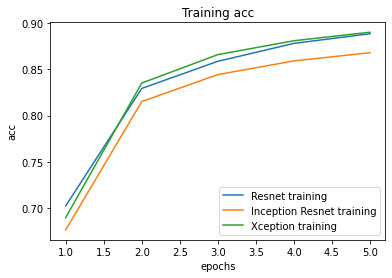

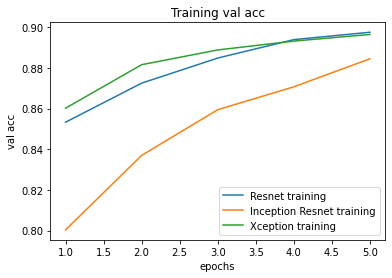

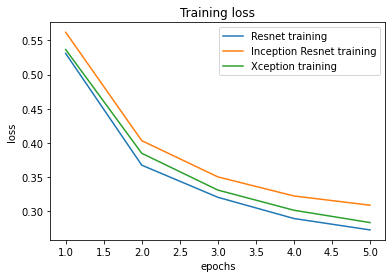

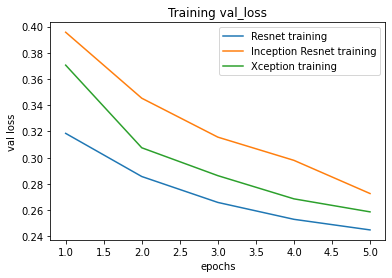

In [ ]:
plot_history(resnet_history, inception_resnet_history, xception_base_model_history)

## Resnet152V2 fine tuning

Up above training we are used tranfer learning. We only trained top layer of the model because the low level layers have more information about image classification. But when we are try to add a couple of convolution layer to training we are getting different results. The technique is calling fine tuning. 

First of all we are allow all model to trainable, then we are chosing which layer will attempt to training and which will not be attempt. Then we are chosing layers and retrained with 10 epochs and fine tuned learning rate (0.00001). 

NOTE: We can directly chose layers but depend on tensorflow documentation first of all we have to allow trainablity for model. Because the batch normalization shouldn't be retrained. I took this technique from https://www.tensorflow.org/tutorials/images/transfer_learning . 

In [ ]:
resnet_base_model.trainable = True

In [ ]:
resnet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, None, None, 3)     0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, None, None, 3)     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

I am checking the last convulation layer name.

In [ ]:
for layer in resnet_base_model.layers:
  print(layer.name, layer.trainable)

input_1 True
conv1_pad True
conv1_conv True
pool1_pad True
pool1_pool True
conv2_block1_preact_bn True
conv2_block1_preact_relu True
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_pad True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_out True
conv2_block2_preact_bn True
conv2_block2_preact_relu True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_pad True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_out True
conv2_block3_preact_bn True
conv2_block3_preact_relu True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_pad True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
max_pooling2d True
conv2_block3_3_conv True
conv2_block3_out True
conv3_block1_preact_bn True
conv3_block1_preact_relu Tru

Except last conv layer, the remaining layers are frozened.

In [ ]:
for layer in resnet_base_model.layers:
  if layer.name[0:5] != 'conv5':
    layer.trainable = False

In [ ]:
for layer in resnet_base_model.layers:
  print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d False
conv2_block3_3_conv False
conv2_block3_out False
conv3_block1_pre

In [ ]:
resnet_fine_tuned_history = train_model(resnet_model, fine_lr, 'resnet_fine_tuned', EPOCHS=10, fine_tuning=True)

Epoch 1/10
689/689 [==============================] - 366s 518ms/step - loss: 0.1302 - accuracy: 0.9551 - val_loss: 0.1679 - val_accuracy: 0.9546

Epoch 00001: val_accuracy improved from -inf to 0.95461, saving model to /content/drive/MyDrive/bbm469_dscp/resnet_fine_tuned/weights.01-0.17.h5
Epoch 2/10
689/689 [==============================] - 354s 513ms/step - loss: 0.1196 - accuracy: 0.9574 - val_loss: 0.1804 - val_accuracy: 0.9528

Epoch 00002: val_accuracy did not improve from 0.95461
Epoch 3/10
689/689 [==============================] - 354s 514ms/step - loss: 0.1109 - accuracy: 0.9606 - val_loss: 0.1721 - val_accuracy: 0.9564

Epoch 00003: val_accuracy improved from 0.95461 to 0.95643, saving model to /content/drive/MyDrive/bbm469_dscp/resnet_fine_tuned/weights.03-0.17.h5
Epoch 4/10
689/689 [==============================] - 354s 513ms/step - loss: 0.1068 - accuracy: 0.9631 - val_loss: 0.1704 - val_accuracy: 0.9597

Epoch 00004: val_accuracy improved from 0.95643 to 0.95969, savi

## InceptionResnet fine tuning

In [ ]:
inception_resnet_base_model.trainable = True

In [ ]:
for layer in inception_resnet_base_model.layers:
  print(layer.name, layer.trainable)

input_3 True
conv2d True
batch_normalization True
activation True
conv2d_1 True
batch_normalization_1 True
activation_1 True
conv2d_2 True
batch_normalization_2 True
activation_2 True
max_pooling2d_3 True
conv2d_3 True
batch_normalization_3 True
activation_3 True
conv2d_4 True
batch_normalization_4 True
activation_4 True
max_pooling2d_4 True
conv2d_8 True
batch_normalization_8 True
activation_8 True
conv2d_6 True
conv2d_9 True
batch_normalization_6 True
batch_normalization_9 True
activation_6 True
activation_9 True
average_pooling2d True
conv2d_5 True
conv2d_7 True
conv2d_10 True
conv2d_11 True
batch_normalization_5 True
batch_normalization_7 True
batch_normalization_10 True
batch_normalization_11 True
activation_5 True
activation_7 True
activation_10 True
activation_11 True
mixed_5b True
conv2d_15 True
batch_normalization_15 True
activation_15 True
conv2d_13 True
conv2d_16 True
batch_normalization_13 True
batch_normalization_16 True
activation_13 True
activation_16 True
conv2d_12 True

In [ ]:
for layer in inception_resnet_base_model.layers:
  if layer.name[0:7] != 'conv_7b' and layer.name[0:9] != 'block8_10':
    layer.trainable = False

In [ ]:
for layer in inception_resnet_base_model.layers:
  print(layer.name, layer.trainable)

input_3 False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d_3 False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_4 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed_5b False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
acti

In [ ]:
inception_resnet_tuned_history = train_model(inception_resnet_model, fine_lr, 'inception_resnet_fine_tuned', EPOCHS=10, fine_tuning=True)

Epoch 1/10
689/689 [==============================] - 227s 315ms/step - loss: 0.2702 - accuracy: 0.8916 - val_loss: 0.2125 - val_accuracy: 0.9208

Epoch 00001: val_accuracy improved from -inf to 0.92084, saving model to /content/drive/MyDrive/bbm469_dscp/inception_resnet_fine_tuned/weights.01-0.21.h5
Epoch 2/10
689/689 [==============================] - 215s 311ms/step - loss: 0.2100 - accuracy: 0.9203 - val_loss: 0.1947 - val_accuracy: 0.9354

Epoch 00002: val_accuracy improved from 0.92084 to 0.93537, saving model to /content/drive/MyDrive/bbm469_dscp/inception_resnet_fine_tuned/weights.02-0.19.h5
Epoch 3/10
689/689 [==============================] - 214s 310ms/step - loss: 0.1925 - accuracy: 0.9284 - val_loss: 0.1833 - val_accuracy: 0.9394

Epoch 00003: val_accuracy improved from 0.93537 to 0.93936, saving model to /content/drive/MyDrive/bbm469_dscp/inception_resnet_fine_tuned/weights.03-0.18.h5
Epoch 4/10
689/689 [==============================] - 214s 310ms/step - loss: 0.1814 - a

## Xception fine tuning

In [ ]:
xception_base_model.trainable = True

In [ ]:
for layer in xception_base_model.layers:
  print(layer.name, layer.trainable)

input_5 True
block1_conv1 True
block1_conv1_bn True
block1_conv1_act True
block1_conv2 True
block1_conv2_bn True
block1_conv2_act True
block2_sepconv1 True
block2_sepconv1_bn True
block2_sepconv2_act True
block2_sepconv2 True
block2_sepconv2_bn True
conv2d_203 True
block2_pool True
batch_normalization_203 True
add True
block3_sepconv1_act True
block3_sepconv1 True
block3_sepconv1_bn True
block3_sepconv2_act True
block3_sepconv2 True
block3_sepconv2_bn True
conv2d_204 True
block3_pool True
batch_normalization_204 True
add_1 True
block4_sepconv1_act True
block4_sepconv1 True
block4_sepconv1_bn True
block4_sepconv2_act True
block4_sepconv2 True
block4_sepconv2_bn True
conv2d_205 True
block4_pool True
batch_normalization_205 True
add_2 True
block5_sepconv1_act True
block5_sepconv1 True
block5_sepconv1_bn True
block5_sepconv2_act True
block5_sepconv2 True
block5_sepconv2_bn True
block5_sepconv3_act True
block5_sepconv3 True
block5_sepconv3_bn True
add_3 True
block6_sepconv1_act True
block6_

In [ ]:
for layer in xception_base_model.layers:
  if layer.name[0:7] != 'block14':
    layer.trainable = False

In [ ]:
for layer in xception_base_model.layers:
  print(layer.name, layer.trainable)

input_5 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d_203 False
block2_pool False
batch_normalization_203 False
add False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_204 False
block3_pool False
batch_normalization_204 False
add_1 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_205 False
block4_pool False
batch_normalization_205 False
add_2 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act False
block5_sepconv3 False
block5_sepconv3_bn Fals

In [ ]:
xception_tuned_history = train_model(xception_model, fine_lr, 'xception_fine_tuned', EPOCHS=10, fine_tuning=True)

Epoch 1/10
689/689 [==============================] - 190s 271ms/step - loss: 0.2416 - accuracy: 0.9066 - val_loss: 0.2218 - val_accuracy: 0.9223

Epoch 00001: val_accuracy improved from -inf to 0.92229, saving model to /content/drive/MyDrive/bbm469_dscp/xception_fine_tuned/weights.01-0.22.h5
Epoch 2/10
689/689 [==============================] - 197s 285ms/step - loss: 0.1965 - accuracy: 0.9269 - val_loss: 0.2086 - val_accuracy: 0.9288

Epoch 00002: val_accuracy improved from 0.92229 to 0.92883, saving model to /content/drive/MyDrive/bbm469_dscp/xception_fine_tuned/weights.02-0.21.h5
Epoch 3/10
689/689 [==============================] - 197s 285ms/step - loss: 0.1819 - accuracy: 0.9352 - val_loss: 0.1906 - val_accuracy: 0.9357

Epoch 00003: val_accuracy improved from 0.92883 to 0.93573, saving model to /content/drive/MyDrive/bbm469_dscp/xception_fine_tuned/weights.03-0.19.h5
Epoch 4/10
689/689 [==============================] - 197s 286ms/step - loss: 0.1674 - accuracy: 0.9402 - val_lo

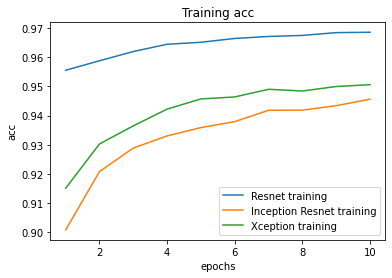

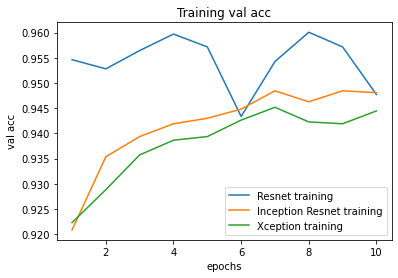

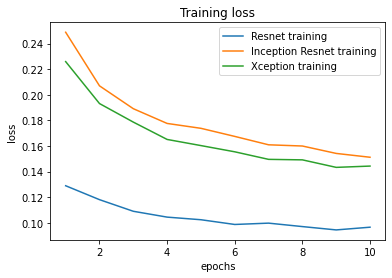

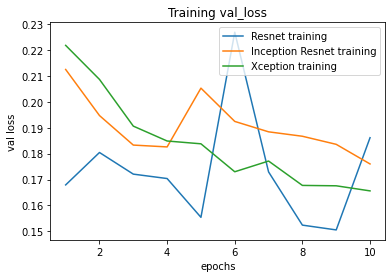

In [ ]:
plot_history(resnet_fine_tuned_history, inception_resnet_tuned_history, xception_tuned_history)

## Evaluation<a class="anchor" id="evaluation"></a>

After finish the tranfer learning and fine tuining, When I examine the model's history graphs, it seems resnet152V2 model is giving better accuracy than others. I already save the best trained models with callbacks. It's important because the resnet152V2 model is reduced accuracy after 8 epoch. 

Even the resnet model is better than others, I want to see all models on test data to ensure which is fine to use.

In [ ]:
xception_model.load_weights('/content/drive/MyDrive/bbm469_dscp/xception_fine_tuned/weights.07-0.18.h5')
resnet_model.load_weights('/content/drive/MyDrive/bbm469_dscp/resnet_fine_tuned/weights.08-0.15.h5')
inception_resnet_model.load_weights('/content/drive/MyDrive/bbm469_dscp/inception_resnet_fine_tuned/weights.07-0.19.h5')

In [ ]:
xception_loss, xception_acc = xception_model.evaluate(test_dataset)
resnet_loss, resnet_acc = resnet_model.evaluate(test_dataset)
incepres_loss, incepres_acc = inception_resnet_model.evaluate(test_dataset)

87/87 [==============================] - 15s 171ms/step - loss: 0.2060 - accuracy: 0.9416


In [ ]:
print('Xception model Test accuracy :', xception_acc)
print('Resnet model Test accuracy :', resnet_acc)
print('Inception resnet model Test accuracy :', incepres_acc)

Xception model Test accuracy : 0.9394049644470215
Resnet model Test accuracy : 0.9535558819770813
Inception resnet model Test accuracy : 0.9415820240974426


Depend on the test dataset accuracies, The resnet152v2 model is best model. 

Visualization of prediction of model. 
* **red text is true label** 
* **blue text is predicted label**

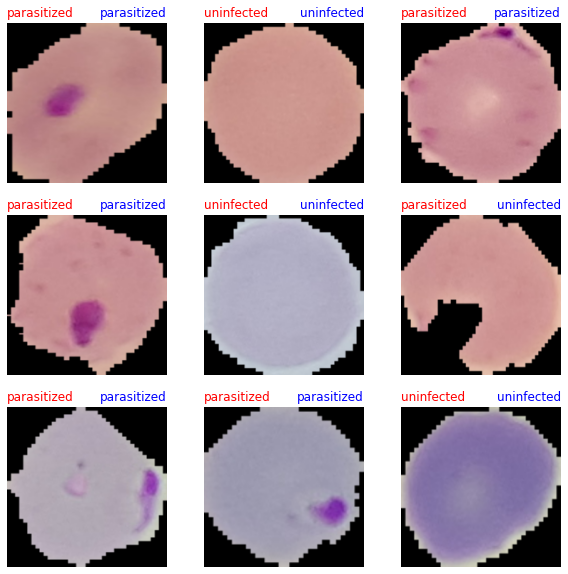

In [ ]:

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = resnet_model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  true = class_names[label_batch[i]]
  pred = class_names[predictions[i]]
  title = plt.title(true, loc='left')
  title2 = plt.title(pred, loc='right')
  plt.setp(title, color='r')
  plt.setp(title2, color='b')
  plt.axis("off")

To evaluate results with classification and confusion matrix, I can't directly use test dataset generator. Therefore in this loop every batch prediction results and true label results added numpy arrays.

In [ ]:
true_labels = np.array([])
pred_labels = np.array([])

for image_batch, label_batch in test_dataset:
  predictions = resnet_model.predict_on_batch(image_batch).flatten()
  predictions = tf.nn.sigmoid(predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)
  
  true_labels = np.append(true_labels, label_batch)
  
  pred_labels = np.append(pred_labels, predictions.numpy())
  
  



In [ ]:
y_true = list(true_labels)
y_pred = list(pred_labels)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      1378
         1.0       0.93      0.98      0.95      1378

    accuracy                           0.95      2756
   macro avg       0.95      0.95      0.95      2756
weighted avg       0.95      0.95      0.95      2756



In [ ]:
def plot_confusion_matrix():
    '''https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
    '''

    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=50)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for Resnet Model ')
    plt.show()

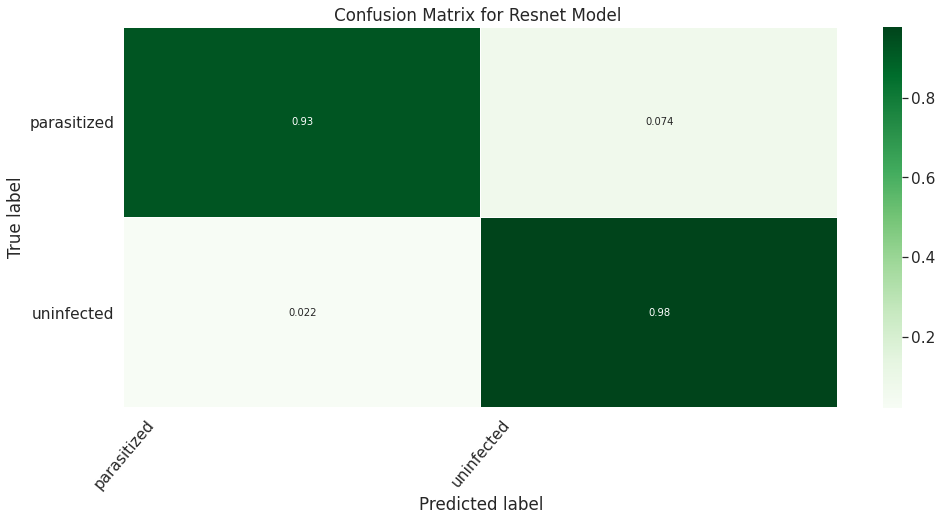

In [ ]:
plot_confusion_matrix()

As a result the 3 different model was trained and tested with same model paramethers and the model ranking best to worse is 

1. Resnet152v2
2. InceptionResnetV2
3. Xception

## References<a class="anchor" id="references"></a>

* [1] https://www.researchgate.net/publication/349105266_Classification_of_Malaria_Cell_Images_with_Deep_Learning_Architectures
* https://towardsdatascience.com/cnn-transfer-learning-fine-tuning-9f3e7c5806b2
* https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38
* https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
* https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras
* https://cs231n.github.io/transfer-learning/
* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://keras.io/api/applications/
* https://keras.io/api/applications/xception/
* https://keras.io/api/applications/inceptionresnetv2/
* https://keras.io/api/applications/resnet/#resnet152v2-function
* https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria